In [1]:
print("ok")

ok


In [2]:
from langchain_openai import ChatOpenAI

In [3]:
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [6]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [8]:
openai_model=ChatOpenAI(model="gpt-4o")

In [9]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-a65484f3-ce97-4321-a329-bc443235dd02-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [11]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [ ]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [15]:
state={}

In [16]:
state["messages"]=[]

In [17]:
state

{'messages': []}

In [18]:
state["messages"].append("hi")

In [19]:
state

{'messages': ['hi']}

In [20]:
state["messages"].append("how are you?")

In [21]:
state

{'messages': ['hi', 'how are you?']}

In [22]:
state["messages"].append("what going on?")

In [23]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [24]:
state["messages"][0]

'hi'

In [25]:
state["messages"][-1]

'what going on?'

In [ ]:
## this state is a dict which containing the message as list and inside the list there could be n numbvers of messages

## this state will be flowing across all the nodes(function) in langgraph

In [26]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=openai_model.invoke(question)
    return {"messages":[response]}

In [27]:
workflow=StateGraph(MessagesState)

In [28]:
workflow.add_node("chatbot",call_model)

In [30]:
workflow.add_edge(START,"chatbot")

In [32]:
workflow.add_edge("chatbot",END)

In [34]:
app=workflow.compile()

In [35]:
from IPython.display import Image,display

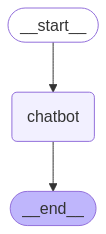

In [36]:
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
input={"messages":["hi my name is sunny"]}

In [39]:
response=app.invoke(input)

In [40]:
response["messages"][-1].content

'Hi Sunny! How can I assist you today?'